In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt    
%matplotlib inline
import json

with open('OpenPoseV2.json') as f:
  file = json.load(f)

data = file['data']
x_train =[]
y_train = []

def labelToNumerical(label):
    if label == 'WarriorPoseI':
        return 0
    if label == 'WarriorPoseII':
        return 1
    if label == 'WarriorPoseIII':
        return 2
    if label == 'TreePose':
        return 3

i = 0
for i in range(len(data)):
    kpsArr = []
    labels = []
    for kps in data[i]['xs'].items():
        kpsArr.append(kps[1])
    for label in data[i]['ys'].items():
        labels.append(labelToNumerical(label[1]))
    x_train.append(kpsArr)
    y_train.append(labels)

x = np.asarray(x_train)
y = np.asarray(y_train)

X_train, X_test, y_train, y_test = train_test_split(x, y.ravel(), test_size=0.2, random_state=3)
eval_set = [(X_train, y_train), (X_test, y_test)]

Finished training...
Accuracy: 92.66%


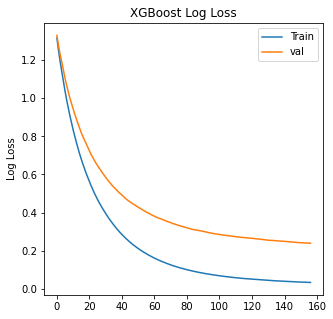

Last val loss: 0.239261




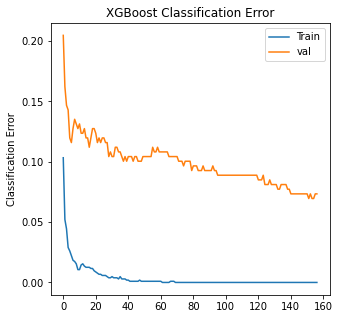

Last val error: 0.073359


In [2]:
clf = XGBClassifier(eta=0.05, 
                    max_depth=10, 
                    objective='multi:softprob', 
                    min_child_weight=1, 
                    subsample=0.635,
                    colsample_bytree=0.61,
                    reg_alpha=0.001,
                    n_estimators= 157,
                    num_class = 4,
                    )

#Train model

clf.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=False)

print('Finished training...')

y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='val')
ax.legend()

plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
print('Last val loss: ' + str(results['validation_1']['mlogloss'][-1]))
print('\n')

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='val')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

print('Last val error: ' + str(results['validation_1']['merror'][-1]))

In [3]:
clf.save_model('../models/xgboost.model')